# Analyse des avis sur les magasins Castorama
***
**Table des matières :**
* [1. Installation et mportation des librairies necessaires](#1)
* [2. Importation des données brutes](#2)
* [3. Nettoyage des données brutes](#3)
* [4. Visualisation](#4)
  * [Note moyenne par ville](#21)
  * [Note moyenne par magasin (en utilisant Business Id)](#22)
  * [Distribution des notes](#23)
  * [Distribution temporelle des ratings ](#24)
    * [Rating en fonction des mois](#212)
    * [Rating par région au cours de l'année](#213)
    * [Rating en fonction des heures de la journée](#214)
* [5. NLP](#5)
  * [Preprocessing](#25)
  * [Analyse des sentiments](#26)
  * [Topic modeling](#27)
  * [Trigram](#28)
***

**Groupe 9 :**
- Adrien DEMAEGDT
- Étienne ROSEAU
- Mohamed Khalil ASLI
- Kahina BEHTANI
- Zhifeng LIANG


<a id='1'></a>
## 1. Installation et importation des librairies necessaires

In [ ]:
!pip uninstall sentencepiece -y
!pip uninstall transformers -y
!pip install hyper
!pip install googletrans==3.1.0a0
!pip install --no-cache-dir transformers sentencepiece
!pip install openpyxl
!pip install spacy
!pip install pyLDAvis.pyLDAvis.gensim
!pip install pyLDAvis.gensim
!pip install wordcloud
!pip install gensim
!pip install top2vec
!pip install evaluate
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import spacy
import plotly.express as px
import plotly.graph_objects as go
spacy.cli.download('fr_core_news_md')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.fr.examples import sentences
import fr_core_news_md
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from transformers import pipeline 
from transformers import PreTrainedTokenizerFast
import evaluate
from top2vec import Top2Vec
import gensim
import pyLDAvis
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel
import nltk
nltk.download('punkt') 
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk import word_tokenize
from collections import Counter
import seaborn as sns
sns.set_style('dark')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<a id='2'></a>
## 2. Importation des données brutes

In [7]:
# On force le type de la colonne Zipcode en string.
df_casto = pd.read_excel("data/raw_datas_projet_M5D_Hetic.xlsx", header=[1], dtype={"Zipcode": str})

<a id='3'></a>
## 3. Nettoyage des données brutes

#### Données à supprimer :
- Nous supprimons les avis de Facebook car ces avis ne contiennent pas de `Rating` qui est important pour notre analyse.

#### Colonnes à supprimer :
- `Updated date`: Presque 85% de données manquantes.
- `Location name`: Pas d'information utile pour notre cas d'usage.
- `Group Id`: Pas d'information utile pour notre cas d'usage.
- `Business Code` : Les colonnes `Business Id` et `Business Code` contiennent une informations identique. Nous supprimons la dernière car il y a 2 `Business Id` qui ont le même `Business Code` (1417) et tous les deux ont des `Rating`.
- `Platform` : Comme nous gardons uniquement les données de Google, on n'a plus besoin de cette colonne.
- `Deleted`: Valueurs uniques "Yes" et "No". Pas d'information utile pour notre cas d'usage.
- `Timezone`: Valueur unique "Europe/Paris". Pas d'information utile pour notre cas d'usage.
- `Response date`: Pas d'information utile pour notre cas d'usage.
- `template_used`: Template pour les questions récurrentes. Pas d'information utile pour notre cas d'usage.
- `Recommended`: Uniquement pour les avis de Facebook. Pas d'information utile pour notre cas d'usage.
- `Response date.1`: 
- `Response.1`: 
- `template_used.1`:
- `Number of comments`: Uniquement pour les avis de Facebook. Pas d'information utile pour notre cas d'usage.
- `Rating.1`: Pas de donnée.
- `Response date.2`: Pas de donnée.
- `Response.2`: Pas de donnée.


#### On garde que les commentaires google reviews

In [8]:
df_casto_google = df_casto[df_casto['Platform'] == 'GOOGLE_MY_BUSINESS']

#### On crée un nouveau dataframe qu'avec les colonnes qui nous intéressent. 

In [9]:
#On crée un nouveau dataframe avec les colonnes qui nous intéressent. 
cols_to_keep = ['Creation date', 'Business Id', 'Group name', 'Address', 'City', 'Zipcode', 'Content', 'Response', 'Rating']
df_casto_google = df_casto_google[cols_to_keep]

#### On enlève les tabulations dans les noms de ville.

In [10]:
# Nettoyage. On enlève les tabulations dans les noms de ville.
df_casto_google["City"] = df_casto_google["City"].str.strip()

#### On rajoute une colonne: moyenne de la ville

In [11]:
# On rajoute une colonne rating moyen par ville. 
Avg_city_rating = df_casto_google[['City','Rating']]
Avg_city_rating = Avg_city_rating.groupby('City', as_index=False)['Rating'].mean()
Avg_city_rating['Rating'] = Avg_city_rating['Rating'].round(2)
avg_rating_dict = dict(zip(Avg_city_rating['City'],Avg_city_rating['Rating']))
df_casto_google['average_city_rating'] = df_casto_google['City'].map(avg_rating_dict)

#### On complete les regions ( group name ) manquantes 

In [12]:
# On trouve les Group name à partir des Zip code.
zipcode_groupname = {
    "92800": "PARIS NORD",
    "91160": "PARIS SUD",
    "77340": "PARIS SUD",
    "95460": "PARIS NORD",
    "75019": "PARIS NORD",
    "95610": "PARIS NORD",
    "33700": "NOUVELLE AQUITAINE",
    "76000": "NORD",
    "49070": "OUEST"
}

df_casto_google["Group name"] = df_casto_google[["Group name", "Zipcode"]].apply(lambda x: zipcode_groupname.get(x["Zipcode"]) or x["Group name"], axis=1)

#### On rajoute la date, le mois, l'heure. 

In [13]:
#On rajoute la date
df_casto_google['date'] = df_casto_google['Creation date'].apply(lambda x: str(x)[0:10] )

#On rajoute le mois
df_casto_google["month"] = df_casto_google['Creation date'].apply(lambda x: str(x)[5:7] )

#On rajoute l'heure exacte
# Arrondi a l'heure la plus proche
def assign_hour (time):
    hour = int(time[0:2])
    minutes = int(time[3:5])
    if minutes >= 30: 
        hour = hour + 1
    if hour == 24:
        hour = 00
    return hour 

# On isole l'heure de la Creation date. 
df_casto_google['hour'] = df_casto_google['Creation date'].apply(lambda x: str(x)[11:16] )
df_casto_google['hour'] = df_casto_google['hour'].apply(lambda x: assign_hour(x) )


<a id='4'></a>
## 4. Visualisation

<a id='21'></a>
#### Note moyenne par ville

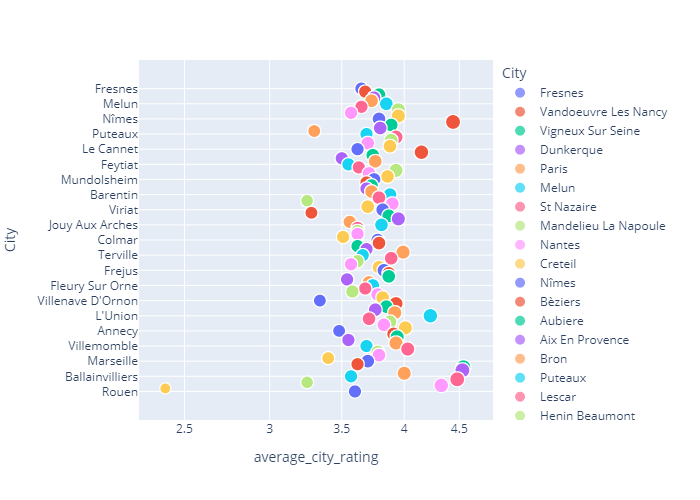

In [18]:
#ignore warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig = px.scatter(df_casto_google, x="average_city_rating", y="City",
         size="average_city_rating", color="City",
                 hover_name="City", log_x=True, size_max=15)
fig.show("png")

<a id='22'></a>
#### Note moyenne par magasin (en utilisant Business Id)

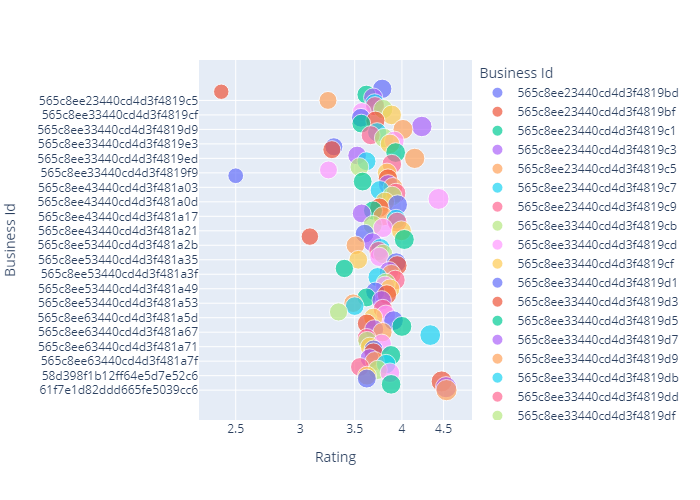

In [20]:
df_magasin=df_casto_google.groupby('Business Id', as_index=False)['Rating'].mean()
fig = px.scatter(df_magasin, x=df_magasin['Rating'], y="Business Id",
         size="Rating", color="Business Id",
                 hover_name="Business Id", log_x=True, size_max=15)
fig.show("png")

<a id='23'></a>
#### Distribution des notes

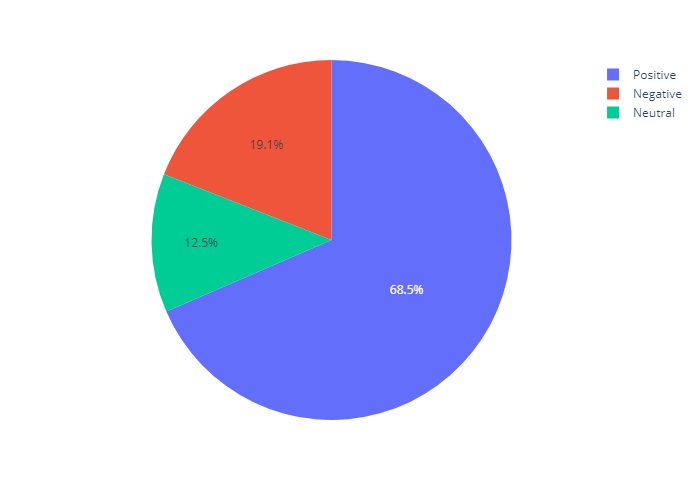

In [21]:
df_casto_google['Rating_categorie']=df_casto_google['Rating'].apply(lambda x: "Negative" if x<3 else "Neutral" if x==3 else "Positive")
fig = px.pie(df_casto_google, values=df_casto_google['Rating_categorie'].value_counts().values, names=df_casto_google['Rating_categorie'].value_counts().index)
fig.show("png")

<a id='24'></a>
#### Distribution temporelle des ratings 

<a id='212'></a>
##### Rating en fonction des mois

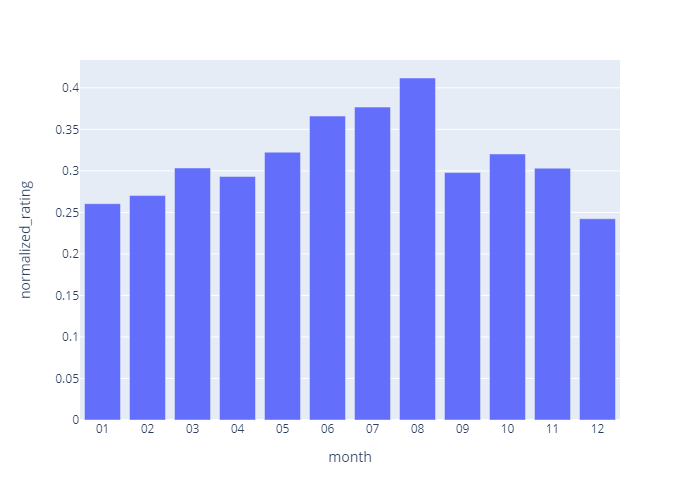

In [22]:
# Moyenne des ratings par mois
df_month_vs_rating = df_casto_google.groupby('month', as_index=False)['Rating'].mean().round(2)
# Nombre de commentaires par mois
df_comment_per_month = df_casto_google.groupby("month", as_index=False).size()

df_month_vs_rating = df_month_vs_rating.merge(df_comment_per_month, how="inner", on="month")

# Moyenne pondérée
# On normalize le rating par la proportion du nombre de commentaires par mois.
total_reviews = df_month_vs_rating["size"].sum()
df_month_vs_rating['normalized_rating'] = df_month_vs_rating["Rating"] * (df_month_vs_rating["size"]/ total_reviews)
fig = px.bar(df_month_vs_rating, x='month', y='normalized_rating')
fig.show("png")




<a id='213'></a>
##### Rating par région au cours de l'année.

Nombre de Rating par region
AUVERGNE RHONE ALPES    6306
OCCITANIE               6092
SUD                     5786
PARIS SUD               5299
PARIS NORD              5270
OUEST                   5263
NOUVELLE AQUITAINE      5173
NORD                    5034
EST                     4461
Name: Group name, dtype: int64


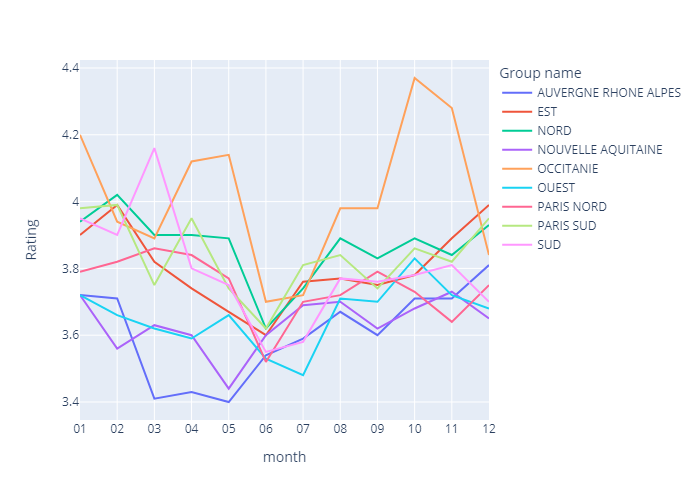

In [23]:
dftest = df_casto_google.copy()
dftest = dftest[dftest['Group name'].notna()]
print(f"Nombre de Rating par region\n{dftest['Group name'].value_counts()}")

dfplot = dftest.groupby(['month', 'Group name'], as_index=False)['Rating'].mean().round(2)
fig = px.line(dfplot, x="month", y="Rating", color='Group name')
fig.show("png")

<a id='214'></a>
##### Rating en fonction des heures de la journée. 

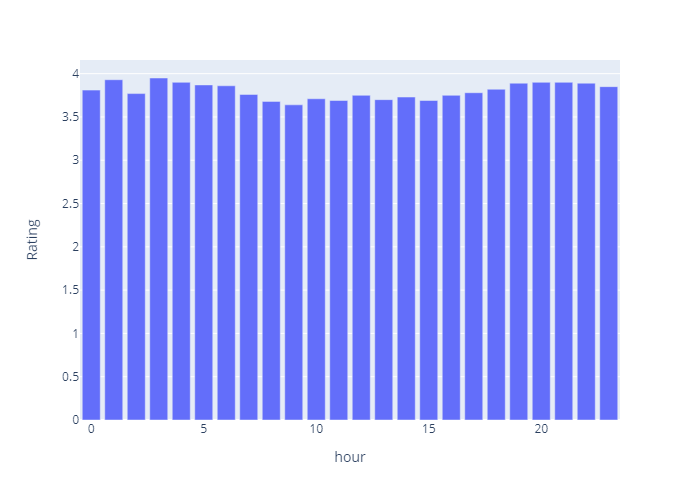

In [24]:
df_hour_vs_rating = df_casto_google.groupby('hour', as_index=False)['Rating'].mean().round(2)
fig = px.bar(df_hour_vs_rating, x='hour', y='Rating')
fig.show("png")

<a id='5'></a>

# 5. NLP

<a id='25'></a>
### Preprocessing

In [ ]:
df_nlp = df_casto_google.copy()

In [ ]:

def clean_content_column(df):

    # On change les Nan en "No Comment" 
    df['Content'] = df['Content'].replace(np.nan, "")

    # fonction qui isole le commentaire de sa traduction
    def clean_comment(comment):
    #check si le comment est traduit:
        if "(Translated by Google)" in comment :

            # Cas Translate au debut: ( Anglais - Francais): On split sur Original et garder deuxieme partie
            #attention : verifier que toutes les lignes ayant translate au debut ont original dans leur comment
            if comment.startswith("(Translated by Google)"):
                return comment.split("(Original)\n")[1]

            # Cas où translate au milieu du comment ( francais - Anglais): on split dessus et on prend la premeire partie ! 
            else:
                return comment.split("(Translated by Google)")[0]
            #else split sur translate et prendre la premiere partie
        else: 
            return comment 
    
# --------------------------- On clean la colonne pour garder que le texte francais  -------------------------------
    
    # On isole le commentaire original de sa traduction
    df["Content_fr"] = df["Content"].apply(lambda x: clean_comment(x) )
    
    # On check la langue avec google translator

    from googletrans import Translator
    detector = Translator()

    def detect_fr_with_googletrans(text):
        if len(text) > 2: 
            return detector.detect(text).lang
        else:
            return 'unknown'

    df['langue'] = df["Content_fr"].apply(detect_fr_with_googletrans)
    return df

# On isole le texte francais
df_nlp = clean_content_column(df_nlp)
df_nlp_fr = df_nlp.loc[(df_nlp["langue"] == "fr")&(df_nlp['Content'].str.len() > 2)]

#### On clean le texte

In [ ]:
# On enleve les \n
df_nlp_fr["Content_fr"] = df_nlp_fr["Content_fr"].apply(lambda x: x.replace("\n",""))

#### On enleve les stopwords et lemmatize

In [14]:
# On charge les stopwords de Spacy
nlp = fr_core_news_md.load()

# Remove Stopwords
def remove_stop_words(doc):
    return [token for token in doc if not token.is_stop]

# Remove punctutation
def remove_punct(doc):
    return [token for token in doc if not token.is_punct]

# Lemmatize
def lemmatize(doc):
    return ' '.join([token.lemma_ for token in doc])

# Stemming
def stemming(doc):
    
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join([stemmer.stem(t) for t in doc if isinstance(t, str)])


def preprocess_content(text, lemmatizing=False, stemming=False) : 
    
    doc = nlp(text)
    removed_punct = remove_punct(doc)
    preprocessed_content = remove_stop_words(removed_punct)
    if lemmatizing :
        preprocessed_content = lemmatize(preprocessed_content)
    elif stemming : 
        preprocessed_content = stemming(text)
        
    return(preprocessed_content)

def process_and_tokenize_text (text):
    text = text.split(" ")
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [each for each in text if len(each) > 3]
    text = [each for each in text if ' ' not in each]

    return text   



In [ ]:
# On enleve les stopwords et on lemmatize
df_nlp_fr["processed_content_fr"] = df_nlp_fr["Content_fr"].apply(lambda x: preprocess_content(x, lemmatizing=True, stemming = False))

In [ ]:
df_nlp_fr.to_csv("df_nlp_fr_2.csv",index=False)

In [15]:
df_nlp_fr = pd.read_csv("df_nlp_fr_2.csv")

<a id='26'></a>
## Analyse des sentiments

In [ ]:
df_sent_analysis= df_nlp_fr.copy()
analyzer = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment",
    truncation=True,max_length=512
)
df_sent_analysis['sentiment']=df_sent_analysis['Content_fr'].apply(lambda content : analyzer(content) if content !=" " else " ")

In [32]:
df_sent_analysis = df_sent_analysis.explode('sentiment').reset_index(drop=True)
# normalize the column of dicts, join back to the remaining dataframe columns, and drop the unneeded column
df_sent_analysis = df_sent_analysis.join(pd.json_normalize(df_sent_analysis.sentiment)).drop(columns=['sentiment'])
df_sent_analysis['label']=df_sent_analysis['label'].replace('star','',regex=True)
df_sent_analysis['label']=df_sent_analysis['label'].replace('s','',regex=True)
#df_test['label']=df_test['label'].fillna(df_test['Rating'].mean())
df_sent_analysis['label']=df_sent_analysis['label'].astype('float')
df_sent_analysis['Rating_categorie']=df_sent_analysis['Rating'].apply(lambda x: "-1" if x<3 else "0" if x==3 else "1")
df_sent_analysis['label_categorie']=df_sent_analysis['label'].apply(lambda x: "-1" if x<3 else "0" if x==3 else "1")
#Evaluate the model
accuracy = evaluate.load("accuracy")
accuracy.compute(references=df_sent_analysis['Rating_categorie'], predictions=df_sent_analysis['label_categorie'])

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'accuracy': 0.853253677165652}

<a id='27'></a>
## Topic Modeling

### Test Top2vec
Le modèle Top2vec n'a pas été retenu suite à la comparaison des résultats des différents modèles

In [ ]:
df_nlp_fr_top2vec=df_nlp_fr.copy()
df_nlp_fr_top2vec["processed_content_fr"]=df_nlp_fr_top2vec["processed_content_fr"].apply(lambda x: process_and_tokenize_text(str(x)))
#Content cleané , lemmatizé etc
docs_process_content = df_nlp_fr_top2vec["processed_content_fr"]
docs_process_content = [str(i) for i in docs_process_content]
model_top2 = Top2Vec(docs_process_content)
topic_sizes, topic_nums = model_top2.get_topic_sizes()
# les 4 premiers topics
topic_words, topic_scores, topic_nums = model_top2.get_topics(4)
topic_words

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

2022-07-25 11:15:19,369 - top2vec - INFO - Pre-processing documents for training
2022-07-25 11:15:23,759 - top2vec - INFO - Creating joint document/word embedding
2022-07-25 11:16:51,633 - top2vec - INFO - Creating lower dimension embedding of documents
2022-07-25 11:18:38,937 - top2vec - INFO - Finding dense areas of documents
2022-07-25 11:18:47,568 - top2vec - INFO - Finding topics


array([['effectuer', 'semaine', 'mail', 'mars', 'appel', 'avril',
        'reponse', 'aucun', 'relance', 'contacter', 'serieux',
        'annoncer', 'catastrophique', 'livrer', 'appeler', 'delai',
        'essayer', 'devoir', 'date', 'injoignable', 'telephonique',
        'recevoir', 'jour', 'tard', 'incompetence', 'tenter', 'domicile',
        'rappeler', 'livraison', 'deplorable', 'catastrophe', 'total',
        'message', 'remboursement', 'argent', 'prevoir', 'promettre',
        'ensuite', 'pret', 'communication', 'retard', 'courant',
        'presente', 'capable', 'attendre', 'suite', 'premier', 'joindre',
        'finir', 'rappel'],
       ['plus', 'parfaire', 'excuser', 'souhaite', 'point', 'relation',
        'lorsque', 'sentir', 'diriger', 'retour', 'positif',
        'interminable', 'contact', 'long', 'repondre', 'evidemment',
        'travailler', 'reconnaitre', 'respecter', 'precis', 'preuve',
        'disposition', 'plupart', 'personne', 'formation', 'fois',
        'visib

In [ ]:
# Associer un topic avec les avis (en utilisant un mot)
docs, doc_scores, docs_ids = model_top2.search_documents_by_keywords(keywords=["personnel"], num_docs=15)
for doc, score, doc_id in zip(docs, doc_scores, docs_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")

Document: 7278, Score: 0.714570164680481
-----------
['magasin', 'bricolage', 'préférer', 'temps', 'particulier', 'concerne', 'espace', 'jardin', 'trouve', 'quasiment', 'besoin', 'bien', 'cher', 'grand', 'enseigne', 'jardinerie', 'face', 'pratique', 'prix', 'cher', 'matériel', 'ressource', 'type', 'terreau', 'paillage', 'revanche', 'plante', 'préférer', 'aller', 'face']
-----------
Document: 18345, Score: 0.7056084871292114
-----------
['être', 'conseiller', 'temps', 'stéphane', 'revêtement', 'vraiment', 'extraordinaire', 'écoute', 'client', 'excellent', 'conseil', 'prendre', 'temps', 'grâce', 'professionnalisme', 'prendre', 'rénovation', 'recommande', '%!et', 'malou', 'peinture', 'jeune', 'femme', 'écoute', 'excellent', 'conseil', 'douceur', 'extrême', 'personnel', 'garder', 'avoir', 'reconnaissance', 'honnêtement', 'rare', 'personne', 'aimer', 'travail', 'vraiment']
-----------
Document: 5126, Score: 0.6828186511993408
-----------
['général', 'personnel', 'compéter', 'agréable', 'fai

In [ ]:
# voir les premiers documents liés au topic
docs, doc_scores, docs_ids = model_top2.search_documents_by_topic(topic_num=3, num_docs=10)
# ici on peut retrouver le commentaire : 
# doc_id correspond à l'index (iloc) du df (soit l'index du doc dans la liste docs_raw_content = dfe.Content.to_list())
for doc, score, doc_id in zip(docs, doc_scores, docs_ids):
    print(f"Doc id: {doc_id}, Score: {score}")
    print("----------")
    print(f"{doc} \n")

Doc id: 8777, Score: 0.960115909576416
----------
['dépanne', 'urgence', 'valoir', 'chausson', 'delzongle', 'tollens', 'etc.'] 

Doc id: 2966, Score: 0.9547338485717773
----------
['bien', 'orienter'] 

Doc id: 12864, Score: 0.9527230262756348
----------
['prix', 'élevé', 'élagueuse', 'magasin', 'bricoramamais', 'super', 'caissière', 'aprem', 'maquillage', 'oeil', 'couleur', 'magasin'] 

Doc id: 20023, Score: 0.9497480988502502
----------
['bien', 'orienter'] 

Doc id: 23279, Score: 0.9482468962669373
----------
['elie', 'conseille'] 

Doc id: 24913, Score: 0.9447064995765686
----------
['manque', 'personnel', 'orienter', 'client'] 

Doc id: 7432, Score: 0.9434621334075928
----------
['offre', 'variéespersonnel', 'compétent', 'accueillir'] 

Doc id: 5202, Score: 0.9432238340377808
----------
['linda', 'super', 'recommander'] 

Doc id: 26209, Score: 0.9419748783111572
----------
['offre', 'limiter', 'personnel', 'réduire'] 

Doc id: 8033, Score: 0.941773533821106
----------
['offre', 'f

<a id='28'></a>
### Bigram et Trigram

In [26]:
df_trigramme=df_nlp_fr.copy()
df_trigramme["processed_content_fr"] = df_trigramme["processed_content_fr"].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>3]))

def compute_trigrams(input_df: pd.DataFrame,
                    text_col: str) -> dict:
    combined_text = ' '.join([x for x in input_df[text_col]])  
    finder = TrigramCollocationFinder.from_words(word_tokenize(combined_text))
    trigrams_dict = {}
    for k, v in finder.ngram_fd.items():
        if len(k[0]) > 1 and len(k[1]) > 1:
            trigrams_dict[k] = v
        else:
            continue
    return trigrams_dict


trigrams = compute_trigrams(df_trigramme, text_col='processed_content_fr')

In [27]:
def plot_trigrams(input_df: pd.DataFrame,
                 text_col: str,
                 top_n: int,
                 rotation=0.8,
                 figsize=(10, 8)) -> None:

    trigrams_dict = compute_trigrams(input_df=input_df, text_col=text_col)
    trigrams_sorted = sorted(trigrams_dict.items(), key=lambda x: x[1], reverse=True)[0:top_n]
    tgram, counts = list(zip(*trigrams_sorted))
    bgstring = list(map(lambda txt: '_'.join(txt), tgram))

    return pd.DataFrame(bgstring).rename(columns={0: "TRIGRAM"}).join(pd.DataFrame(list(counts)).rename(columns={0: "Count"}))

### TRIGRAM AVIS POSITIFS

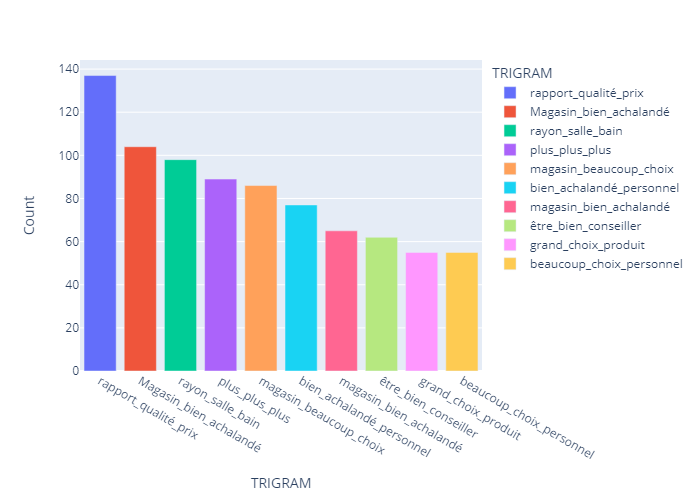

In [30]:
df_visual=plot_trigrams(input_df=df_trigramme[df_trigramme['Rating']>=4].reset_index(drop=True), text_col='processed_content_fr',top_n=10, rotation=45, figsize=(20, 6))
fig = px.bar(df_visual, x='TRIGRAM', y='Count',color='TRIGRAM')
fig.show("png")

### TRIGRAM AVIS NEGATIFS

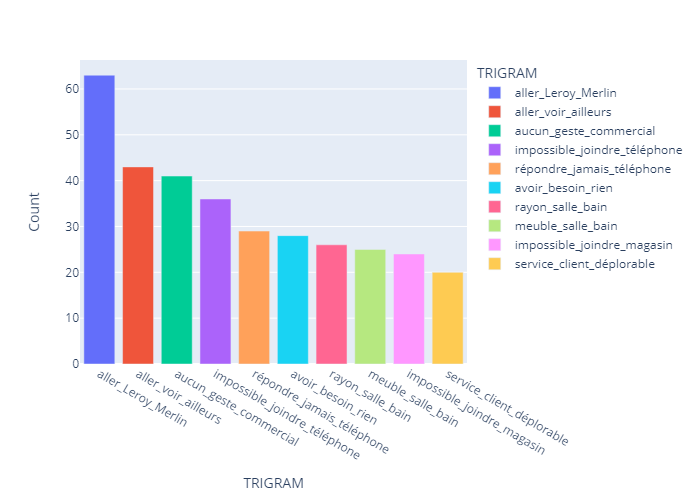

In [31]:
df_visual=plot_trigrams(input_df=df_trigramme[df_trigramme['Rating']<3].reset_index(drop=True), text_col='processed_content_fr',top_n=10, rotation=45, figsize=(20, 6))
fig = px.bar(df_visual, x='TRIGRAM', y='Count',color='TRIGRAM')
fig.show("png")

### NMF

In [ ]:
#Stopwords à enlever 

words = ["bien, bon"]

df_nlp_fr["processed_content_fr"] = df_nlp_fr["processed_content_fr"].apply(lambda x: str(x).replace("bien","").replace("bon","") )

#Répartition en 2 dataframes
# GOOD
df_nlp_fr_good = df_nlp_fr.loc[df_nlp_fr["Rating"] > 3 ]

#BAD
df_nlp_fr_bad = df_nlp_fr.loc[df_nlp_fr["Rating"] < 3 ]


In [ ]:
# GOOD Reviews
# Test AMELIORATION 1 : BAD Reviews


df_nlp_fr_good["tokenized_content"] = df_nlp_fr_good["processed_content_fr"].apply(lambda x: process_and_tokenize_text(x) )

# DEFINE VECTORIZER TF-IDF

# min_df: nombre minimum d'occurence du mot dans le corpus
vect = TfidfVectorizer(min_df=50, max_df= 0.85, ngram_range=(1, 2), preprocessor=' '.join )

#define content 
X_train = df_nlp_fr_good['tokenized_content']
# X_train, X_test = train_test_split(docs, train_size=0.8)

# Fit and transform
tfidf = vect.fit_transform(X_train)

# Create an NMF instance: model
model = NMF (
        n_components=6,
        init='nndsvd',
        max_iter=500,
        l1_ratio=0.0,
        solver='cd',
        alpha=0.0,
        tol=1e-4,
        random_state=5
    ).fit(tfidf)
 
# Fit the model to TF-IDF
# Transform the TF-IDF: nmf_features
nmf_features = model.fit_transform(tfidf)
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())

topics = {}
for topic in range(components_df.shape[0]):
    topic_words = components_df.iloc[topic]
    topics[topic] = topic_words.nlargest(15).to_frame().index.tolist()

df_topics = pd.DataFrame(topics)
print(df_topics)
# On remanie le dataframe en deux colonnes : topic_number et topic_words

all_topics_words = []
topic_numbers = df_topics.columns.tolist()

for topic in topic_numbers :
    topic_words = " ".join(df_topics[topic].tolist())
    all_topics_words.append(topic_words)
df_topics_good_final = pd.DataFrame({"topic_number": topic_numbers , "topic_words": all_topics_words, "main_word": ["vendeur", "magasin", "choix", "personnel", "casto", "accueil"]})

# PREDICTION ON  REVIEWS X_train

# Transform the new data with the fitted models
df_nlp_fr_good["tokenized_content"] = df_nlp_fr_good["processed_content_fr"].apply(lambda x: process_and_tokenize_text(x) )

docs = df_nlp_fr_good.tokenized_content

# # Get prediction
tfidf_new = vect.transform(docs)
X_new = model.transform(tfidf_new)

predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# # Assign predictions to dataframe
df_nlp_fr_good['topic_number'] = predicted_topics

# Join with topic word & main word

# X_test["processed_content_fr"] = X_test["tokenized_content"].apply(lambda x: " ".join(x))

df_prediction_good = df_nlp_fr_good.merge(df_topics_good_final, how="inner", on="topic_number")

# # df_nlp_fr_bad['topic_number'] = predicted_topics

# df_prediction_good = df_prediction.merge(df_topics_final, on="topic_number", how="outer")
df_prediction_good


<ipython-input-33-2f85aef19a0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp_fr_good["tokenized_content"] = df_nlp_fr_good["processed_content_fr"].apply(lambda x: process_text(x) )
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
                0                  1                 2                      3  \
0         conseil            magasi

,Unnamed: 0,Creation date,Business Id,Group name,Address,City,Zipcode,Content,Response,Rating,Content_fr,langue,processed_content_fr,tokenized_content,topic_number,topic_words,main_word
0,2,2022-05-31 22:05:35.998,565c8ee63440cd4d3f481a67,PARIS SUD,4 rue De La Longueraie,Vigneux Sur Seine,91270,"Dans un petit appartement, je bricole peu.... ...","Bonjour Madame,\nNous vous remercions chaleure...",5.0,"Dans un petit appartement, je bricole peu.... ...",fr,petit appartement bricol trouve solution quest...,"[petit, appartement, bricol, trouve, solution,...",2,choix beaucoup beaucoup choix grand prix grand...,choix
1,6,2022-05-31 20:53:48.663,565c8ee63440cd4d3f481a71,OUEST,route De La Côte De Nacre,St Nazaire,44600,"Beaucoup de bons conseils, tarifs parfois élev...","Bonjour Thierry Gaumont,\nMerci vivement d’avo...",4.0,"Beaucoup de bons conseils, tarifs parfois élev...",fr,beaucoup conseil tarif élevé accessoire,"[beaucoup, conseil, tarif, élevé, accessoire]",2,choix beaucoup beaucoup choix grand prix grand...,choix
2,21,2022-05-31 19:01:23.346,565c8ee33440cd4d3f4819e5,AUVERGNE RHONE ALPES,aéroport De Lyon Bron Case 06,Bron,69500,"Beaucoup de choix, prix moyens.\n\n(Translated...","Bonjour Odile Palmigiani,\nToute notre équipe ...",4.0,"Beaucoup de choix, prix moyens.",fr,beaucoup choix prix moyen,"[beaucoup, choix, prix, moyen]",2,choix beaucoup beaucoup choix grand prix grand...,choix
3,48,2022-05-31 16:00:50.702,565c8ee63440cd4d3f481a6d,AUVERGNE RHONE ALPES,rue Des Marais,Chambery,73000,"Rien à redire,très bon magasin avec de larges ...",Bonjour violaine\nMerci pour votre commentaire...,5.0,"Rien à redire,très bon magasin avec de larges ...",fr,rien redire magasin large choix service drive...,"[rien, redire, magasin, large, choix, service,...",2,choix beaucoup beaucoup choix grand prix grand...,choix
4,56,2022-05-31 15:03:16.395,565c8ee43440cd4d3f4819fd,PARIS SUD,ZAC Du Champs De Foire,Melun,77000,Magasin avec beaucoup d'articles ayant un rapp...,"Bonjour chantal perathoner,\nMille mercis d’av...",4.0,Magasin avec beaucoup d'articles ayant un rapp...,fr,Magasin beaucoup article rapport qualité prix ...,"[magasin, beaucoup, article, rapport, qualité,...",2,choix beaucoup beaucoup choix grand prix grand...,choix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16255,48723,2021-06-01 13:22:42.146,565c8ee53440cd4d3f481a3d,SUD,avenue De Draguignan,La Garde,83130,(Translated by Google) Thanks to Cindy from th...,"Bonjour Clément,\nmerci pour votre retour, et ...",5.0,Merci a Cindy du service après-vente pour sa p...,fr,Cindy service après-vente persévérance dame a...,"[cindy, service, après-vente, persévérance, da...",5,accueil super service super accueil accueil co...,accueil
16256,48734,2021-06-01 12:01:32.584,565c8ee43440cd4d3f481a0d,EST,76 route De Metz,Jouy Aux Arches,57130,(Translated by Google) I was looking for an it...,Bonjour Mme Florence Porte. Merci pour vos 4 é...,4.0,"Je cherchais un article, et pour une fois, j a...",fr,chercher article fois j rapidement trouver ven...,"[chercher, article, fois, rapidement, trouver,...",5,accueil super service super accueil accueil co...,accueil
16257,48762,2021-06-01 09:11:38.968,565c8ee33440cd4d3f4819d5,PARIS NORD,zone industrielle De Paris Nord Ii,Roissy En France,95700,(Translated by Google) the service set up duri...,"Bonjour,\nPetits ou grands, merci d’avoir réal...",4.0,le service mis en place pendant le covid est b...,fr,service mettre place covid organiser retirer ...,"[service, mettre, place, covid, organiser, ret...",5,accueil super service super accueil accueil co...,accueil
16258,48768,2021-06-01 08:50:40.369,565c8ee33440cd4d3f4819ed,NORD,Parc de l'estuaire r.n. 15 route nationale 15,Gonfreville L'Orcher,76700,Très bien\n\n(Translated by Google)\nVery well,Bonjour jean-claude Oussin et merci d’avoir pr...,4.0,Très bien,fr,,[],5,accueil super service super accueil accueil co...,accueil


In [ ]:
# BAD Reviews


df_nlp_fr_bad["tokenized_content"] = df_nlp_fr_bad["processed_content_fr"].apply(lambda x: process_and_tokenize_text(x) )

# Amelioration: enlever les mots qui ont une faible frequence ( mots uniques par exemple)


# DEFINE VECTORIZER TF-IDF

# min_df: nombre minimum d'occurence du mot dans le corpus
vect = TfidfVectorizer(min_df=50, max_df= 0.85, ngram_range=(1, 2), preprocessor=' '.join )

#define content 
# docs = df_nlp_fr_bad.processed_content_fr
docs = df_nlp_fr_bad['tokenized_content']
#X_train, X_test = train_test_split(docs, train_size=0.8)

# Fit and transform
# tfidf = vect.fit_transform(X_train)
tfidf = vect.fit_transform(docs)

# Create an NMF instance: model
model = NMF (
        n_components=6,
        init='nndsvd',
        max_iter=500,
        l1_ratio=0.0,
        solver='cd',
        alpha=0.0,
        tol=1e-4,
        random_state=5
    ).fit(tfidf)
 
# Fit the model to TF-IDF

 
# Transform the TF-IDF: nmf_features
nmf_features = model.fit_transform(tfidf)
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
# components_df = pd.DataFrame(vect.get_feature_names(), columns=model.components_)

topics = {}
for topic in range(components_df.shape[0]):
    topic_words = components_df.iloc[topic]
    # print(f'For topic {topic+1} the words with the highest value are:')
    # print('\n')
    topics[topic] = topic_words.nlargest(15).to_frame().index.tolist()

df_topics = pd.DataFrame(topics)
print(df_topics)
# On remanie le dataframe en deux colonnes : topic_number et topic_words

all_topics_words = []
topic_numbers = df_topics.columns.tolist()

for topic in topic_numbers :
    topic_words = " ".join(df_topics[topic].tolist())
    all_topics_words.append(topic_words)
df_topics_bad_final = pd.DataFrame({"topic_number": topic_numbers , "topic_words": all_topics_words, "main_word": ["service_client/telephone", "vendeur", "caisse", "personnel", "site_internet/livraison", "concurrence"]})

# PREDICTION ON  REVIEWS X_train

# Transform the new data with the fitted models
df_nlp_fr_bad["tokenized_content"] = df_nlp_fr_bad["processed_content_fr"].apply(lambda x: process_and_tokenize_text(x) )

docs = df_nlp_fr_bad.tokenized_content

# # Get prediction
tfidf_new = vect.transform(docs)
X_new = model.transform(tfidf_new)

predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# # Assign predictions to dataframe
df_nlp_fr_bad['topic_number'] = predicted_topics

# Join with topic word & main word

# X_test["processed_content_fr"] = X_test["tokenized_content"].apply(lambda x: " ".join(x))

df_prediction_bad = df_nlp_fr_bad.merge(df_topics_bad_final, how="inner", on="topic_number")


# df_prediction_good = df_prediction.merge(df_topics_final, on="topic_number", how="outer")



In [ ]:
# PREDICTION ON NEW REVIEWS ( X_TEST )

# Transform the new data with the fitted models
df_nlp_fr_bad["tokenized_content"] = df_nlp_fr_bad["processed_content_fr"].apply(lambda x: process_and_tokenize_text(x) )
new_texts = df_nlp_fr_bad["tokenized_content"]
docs = df_nlp_fr_bad.tokenized_content

# vectorizer = TfidfVectorizer(min_df=50, max_df= 0.85, ngram_range=(1, 2), preprocessor=' '.join  )
# # Fit and transform
# X = vectorizer.fit_transform(docs)


tfidf_new = vect.transform(X_test)
X_new = model.transform(tfidf_new)

# Get the top predicted topic

predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]
# Add to the df
X_test = pd.DataFrame(X_test)
X_test['topic_number'] = predicted_topics

X_test["processed_content_fr"] = X_test["tokenized_content"].apply(lambda x: " ".join(x))

df_prediction = df_nlp_fr_bad.merge(X_test, how="inner", on="processed_content_fr")

# df_nlp_fr_bad['topic_number'] = predicted_topics

df_prediction = df_prediction.merge(df_topics_final, on="topic_number", how="outer")

# df_prediction represente les predictions sur l'echantillon Test
df_prediction.drop(columns=["langue"], inplace=True)


In [ ]:
# Cleanning et préparation des dataframes pour pouvoir les intégrer sur streamlit
df_bad_predictions = pd.read_csv("./topic_bad_reviews.csv")
df_bad_predictions.reset_index(drop=True,inplace=True)
df_bad_predictions_visu=df_bad_predictions[['Creation date','City','Address','topic_number','main_word']]
df_bad_predictions_visu['City']=df_bad_predictions_visu['City'].str.strip()
df_bad_predictions_visu["Address Without Number"] = df_bad_predictions_visu["Address"].apply(lambda x: re.sub(r"\d+\sb\s|^\d+-\d+\s|^\d+\s", "", x).title())
df_bad_predictions_visu['Creation date']= pd.to_datetime(df_bad_predictions_visu['Creation date'])
df_bad_predictions_visu["Date"] = df_bad_predictions_visu["Creation date"].dt.date
df_bad_predictions_visu=df_bad_predictions_visu[['Date','City','Address Without Number','topic_number','main_word']]
df_bad_predictions_visu["main_word"]=df_bad_predictions_visu["main_word"].str.title()
df_bad_predictions_visu["main_word"]=df_bad_predictions_visu["main_word"].replace("Service_Client/Telephone","Service client / Téléphone", regex=True)
df_bad_predictions_visu["main_word"]=df_bad_predictions_visu["main_word"].replace("Site_Internet/Livraison","Site internet / Livraison", regex=True)
df_bad_predictions_visu["Count"]=1
df_good_predictions = pd.read_csv("./topic_good_reviews.csv")
df_good_predictions.reset_index(drop=True,inplace=True)
df_good_predictions_visu=df_good_predictions[['Creation date','City','Address','topic_number','main_word']]
df_good_predictions_visu['City']=df_good_predictions_visu['City'].str.strip()
df_good_predictions_visu["Address Without Number"] = df_good_predictions_visu["Address"].apply(lambda x: re.sub(r"\d+\sb\s|^\d+-\d+\s|^\d+\s", "", x).title())
df_good_predictions_visu['Creation date']= pd.to_datetime(df_good_predictions_visu['Creation date'])
df_good_predictions_visu["Date"] = df_good_predictions_visu["Creation date"].dt.date
df_good_predictions_visu=df_good_predictions_visu[['Date','City','Address Without Number','topic_number','main_word']]
df_good_predictions_visu["main_word"]=df_good_predictions_visu["main_word"].str.title()
df_good_predictions_visu["Count"]=1
df_bad_predictions_visu.to_csv('NMF_bad_reviews.csv',index=False)
df_good_predictions_visu.to_csv('NMF_good_reviews.csv',index=False)

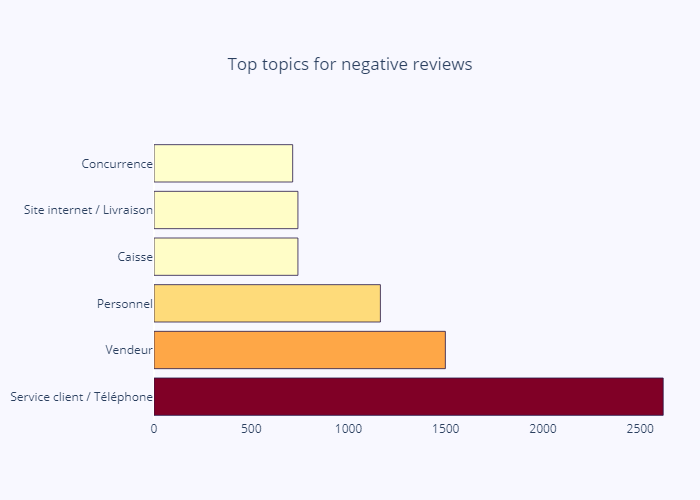

In [34]:

fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_bad_predictions_visu['main_word'].value_counts().index.tolist(),
    x=df_bad_predictions_visu['main_word'].value_counts().values,
    name='Négative',
    orientation='h',
    marker=dict(
        color=df_bad_predictions_visu['main_word'].value_counts().values,
        colorscale="ylorrd",
        line=dict(color='rgba(38, 24, 74, 0.8)', width=1)
    )
))
fig.update_layout(barmode='stack',title_text="Top topics for negative reviews",title_x=0.5,xaxis=dict(
        showgrid=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        showline=False
    ),paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80))
fig.update_xaxes(categoryorder='total ascending')
fig.show("png")

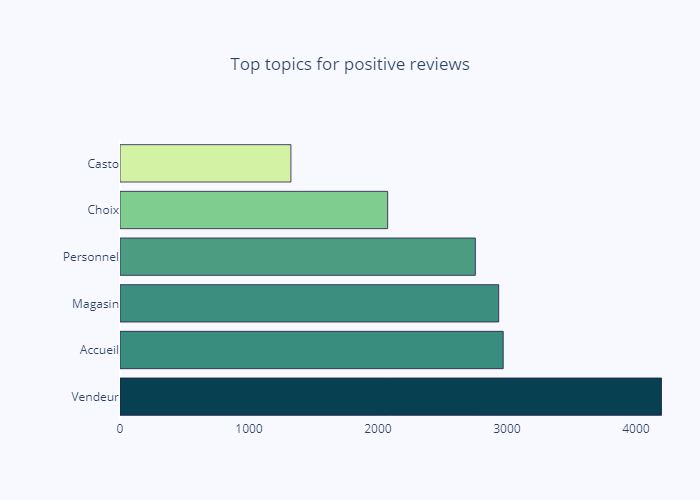

In [35]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_good_predictions_visu['main_word'].value_counts().index.tolist(),
    x=df_good_predictions_visu['main_word'].value_counts().values,
    name='Positive',
    orientation='h',
    marker=dict( color=df_good_predictions_visu['main_word'].value_counts().values,
        colorscale="Emrld",
        line=dict(color='rgba(38, 24, 74, 0.8)', width=1) 
    )
))
fig.update_layout(barmode='stack',title_text="Top topics for positive reviews",title_x=0.5,xaxis=dict(
        showgrid=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        showline=False
    ),paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80))
fig.update_xaxes(categoryorder='category ascending')
fig.show("png")

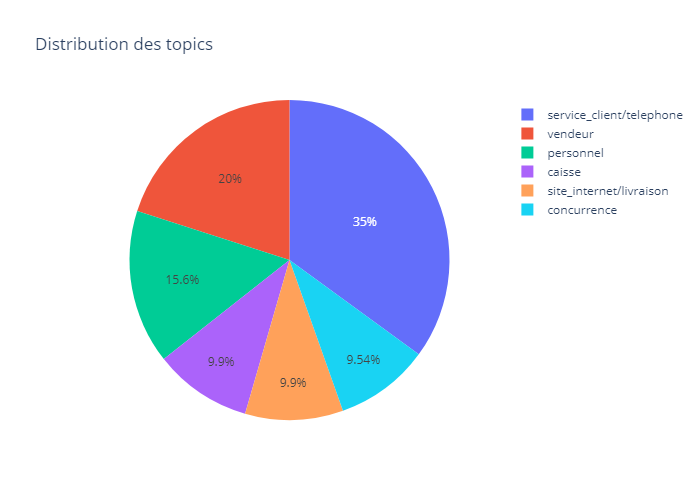

In [36]:
# Visualisation BAD REVIEWS
# Pourcentage par topic dans les bads reviews
df_vis = df_bad_predictions['main_word'].value_counts().to_frame().reset_index().rename(columns={"index": "main_word", "main_word": "nb"})
fig = px.pie(df_vis, values='nb', names='main_word', title='Distribution des topics')
fig.show("png")



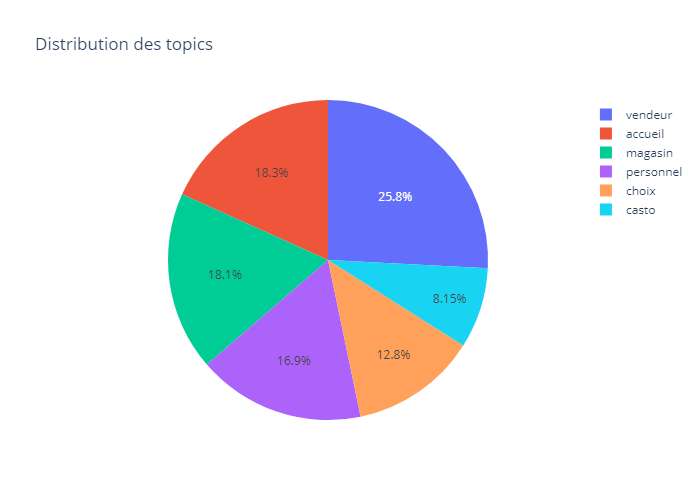

In [37]:
# Visualisation GOOD REVIEWS
# Pourcentage par topic dans les bads reviews
df_vis = df_good_predictions['main_word'].value_counts().to_frame().reset_index().rename(columns={"index": "main_word", "main_word": "nb"})
fig = px.pie(df_vis, values='nb', names='main_word', title='Distribution des topics')
fig.show("png")

### LDA

In [23]:
df_nlp_fr["tokens_fr_spacy"] = df_nlp_fr["processed_content_fr"].apply(lambda x: process_and_tokenize_text(str(x)))

In [24]:
dictionary = corpora.Dictionary(df_nlp_fr["tokens_fr_spacy"])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df_nlp_fr["tokens_fr_spacy"]]
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)
lda_model.print_topics()

[(0,
  '0.019*"vendeur" + 0.018*"faire" + 0.015*"acheter" + 0.015*"aller" + 0.013*"client" + 0.013*"rayon" + 0.013*"magasin" + 0.011*"castorama" + 0.009*"venir" + 0.008*"voir"'),
 (1,
  '0.062*"choix" + 0.061*"prix" + 0.047*"produit" + 0.043*"beaucoup" + 0.030*"trouver" + 0.028*"magasin" + 0.022*"cher" + 0.020*"caisse" + 0.020*"qualité" + 0.020*"rayon"'),
 (2,
  '0.040*"conseil" + 0.039*"rayon" + 0.034*"accueil" + 0.030*"vendeur" + 0.025*"super" + 0.021*"conseiller" + 0.019*"être" + 0.016*"équipe" + 0.013*"professionnel" + 0.013*"recommande"'),
 (3,
  '0.027*"commande" + 0.018*"magasin" + 0.017*"service" + 0.016*"stock" + 0.015*"jour" + 0.011*"passer" + 0.010*"livraison" + 0.010*"site" + 0.009*"attente" + 0.009*"client"'),
 (4,
  '0.094*"magasin" + 0.086*"bien" + 0.083*"personnel" + 0.031*"trouve" + 0.022*"agréable" + 0.018*"bricolage" + 0.015*"disponible" + 0.014*"falloir" + 0.014*"vendeur" + 0.014*"sympa"')]

In [25]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix)) 


Perplexity:  -7.301225359841624


In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_nlp_fr["tokens_fr_spacy"][df_nlp_fr["tokens_fr_spacy"].str.len()!=0], dictionary=dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.5992333817598583

In [20]:
warnings.filterwarnings("ignore",category=FutureWarning)
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163774  0.028530       1        1  30.965046
3     -0.269585 -0.003678       2        1  27.862606
2      0.093943  0.187262       3        1  16.233019
4      0.223824  0.098010       4        1  14.175659
1      0.115592 -0.310124       5        1  10.763670, topic_info=           Term         Freq        Total Category  logprob  loglift
160   personnel  4090.000000  4090.000000  Default  30.0000  30.0000
104        bien  5631.000000  5631.000000  Default  29.0000  29.0000
17      magasin  8774.000000  8774.000000  Default  28.0000  28.0000
37        choix  2314.000000  2314.000000  Default  27.0000  27.0000
169        prix  2261.000000  2261.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
18     matériel   215.716115   501.762361   Topic5  -5.1535   1.3848
379        long   189.293719   384.514536   Topic5  -5.2841   1.5203
257       stock   257.917908  1825.323425   Topic5  -4.9748   0.2721
1     bricolage   222.845677  1110.468316   Topic5  -5.1210   0.6229
174  conseiller   222.882421  1925.802532   Topic5  -5.1208   0.0725

[305 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
585       3  0.996548    abordable
771       4  0.989291   accessible
114       1  0.221333      accueil
114       3  0.778522      accueil
404       4  0.994987  accueillant
...     ...       ...          ...
57        5  0.995001        élevé
112       3  0.998939       équipe
113       1  0.319144         être
113       2  0.308872         être
113       3  0.371921         être

[363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

In [27]:
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df_nlp_fr["tokens_fr_spacy"][df_nlp_fr["tokens_fr_spacy"].str.len()!=0]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
        # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=df_nlp_fr["tokens_fr_spacy"][df_nlp_fr["tokens_fr_spacy"].str.len()!=0])
df_topic_sents_keywords.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,tokens_fr_spacy
0,3,0.4128,"commande, magasin, service, stock, jour, passer, livraison, site, attente, client","[parking, image, magasin, délabré, vendeur, caissier, tire, gueule, vendeur, parler, impression, cacher, finir, ponpon, garonne, toilette, état, pitoyable, barre, inox, rouiller, toilette, fuir, robinet, fixer, magasin, matériel, bricolage, devoir, mettre, plein, terminer, fameux, proverbe, cordonnier, chausser]"
1,1,0.4439,"choix, prix, produit, beaucoup, trouver, magasin, cher, caisse, qualité, rayon","[petit, appartement, bricol, trouve, solution, question, déco, aménagement, accessoire, maison, grand, choix, rayon]"
2,4,0.6492,"magasin, bien, personnel, trouve, agréable, bricolage, disponible, falloir, vendeur, sympa","[magasin, maximum, article, référence, espace, limité, trouve, vendeur, savoir, devenir, rare]"
3,1,0.7000,"choix, prix, produit, beaucoup, trouver, magasin, cher, caisse, qualité, rayon","[beaucoup, conseil, tarif, élevé, accessoire]"
4,1,0.5912,"choix, prix, produit, beaucoup, trouver, magasin, cher, caisse, qualité, rayon","[chose, onny, trouver, venir, chercher, obliger, aller, castrai, cannet, antibes]"
5,2,0.6457,"conseil, rayon, accueil, vendeur, super, conseiller, être, équipe, professionnel, recommande","[achat, element, salle, bain, satisfaisant, conseil, victoria]"
6,0,0.4084,"vendeur, faire, acheter, aller, client, rayon, magasin, castorama, venir, voir","[castorama, dire, antichambre, enfer, quelqu', faire, croire, parisien, bricoler, bande, bras, cassé, savoir, faire, différence, pigeon, bricoler, général, appeler, magasin, paniqué, style, casser, chasse, haaaan"", bref, magasin, plein, paris, angoisse, parisien, pire, localisation, place, clichy, jonction, ligne, ligne, enfer]"
7,3,0.5555,"commande, magasin, service, stock, jour, passer, livraison, site, attente, client","[grand, équipe, professionnalisme, commande, carrelage, rapatriement, magasin, bien, passer, livraison, être, faire, rapidement]"
8,0,0.6854,"vendeur, faire, acheter, aller, client, rayon, magasin, castorama, venir, voir","[avoir, besoin, rien, falloir, aller, voir, vendeur, fuir, client, accueil, détestable, pauvre, hôtess, caisse, prendre, grade, cause, incompétence, vendeur]"
9,2,0.7197,"conseil, rayon, accueil, vendeur, super, conseiller, être, équipe, professionnel, recommande","[remercier, équipe, casto, particulièrement, sofia, qualité, service, conseil, super, expérience, client, vivre, aujourd’hui]"


In [29]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Topic_label']=df_dominant_topic['Dominant_Topic'].apply(lambda x: "Vendeur" if x==0 else "Choix / Produits" if x==1 else "Conseil" if x==2 else "Commandes / Services" if x==3 else "Magasin / Personnel")
df_visu=df_nlp_fr.join(df_dominant_topic)
df_visu['Rating_labe']=df_visu['Rating'].apply(lambda x: "Negative" if x<3 else "Neutral" if x==3 else "Positive")

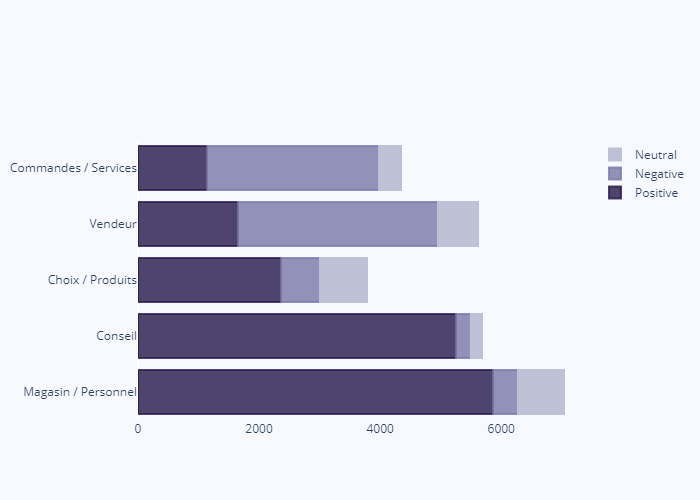

In [31]:
warnings.filterwarnings("ignore",category=DeprecationWarning)
fig = go.Figure()
fig.add_trace(go.Bar(
    y=df_visu['Topic_label'][df_visu['Rating_labe']=='Positive'].value_counts().index.tolist(),
    x=df_visu['Topic_label'][df_visu['Rating_labe']=='Positive'].value_counts().values,
    name='Positive',
    orientation='h',
    marker=dict(
        color='rgba(38, 24, 74, 0.8)',
        line=dict(color='rgba(38, 24, 74, 0.8)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=df_visu['Topic_label'][df_visu['Rating_labe']=='Negative'].value_counts().index.tolist(),
    x=df_visu['Topic_label'][df_visu['Rating_labe']=='Negative'].value_counts().values,
    name='Negative',
    orientation='h',
    marker=dict(
        color='rgba(122, 120, 168, 0.8)',
        line=dict(color='rgba(122, 120, 168, 0.8)', width=2)
    )
))
fig.add_trace(go.Bar(
    y=df_visu['Topic_label'][df_visu['Rating_labe']=='Neutral'].value_counts().index.tolist(),
    x=df_visu['Topic_label'][df_visu['Rating_labe']=='Neutral'].value_counts().values,
    name='Neutral',
    orientation='h',
    marker=dict(
        color='rgba(190, 192, 213, 1)',
        line=dict(color='rgba(190, 192, 213, 1)', width=2)
    )
))

fig.update_layout(barmode='stack',xaxis=dict(
        showgrid=False,
        showline=False
    ),
    yaxis=dict(
        showgrid=False,
        showline=False
    ),paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=80))
fig.show("png")

In [32]:
df_visu['Creation date']= pd.to_datetime(df_visu['Creation date'])
df_visu['Creation date']=df_visu['Creation date'].dt.date

In [33]:
df_visu['Month date']=df_visu['Creation date'].apply(lambda x: x.month)
df_visu['Month date'].value_counts().index.astype('str')

Index(['8', '6', '7', '5', '3', '4', '10', '11', '2', '9', '1', '12'], dtype='object')

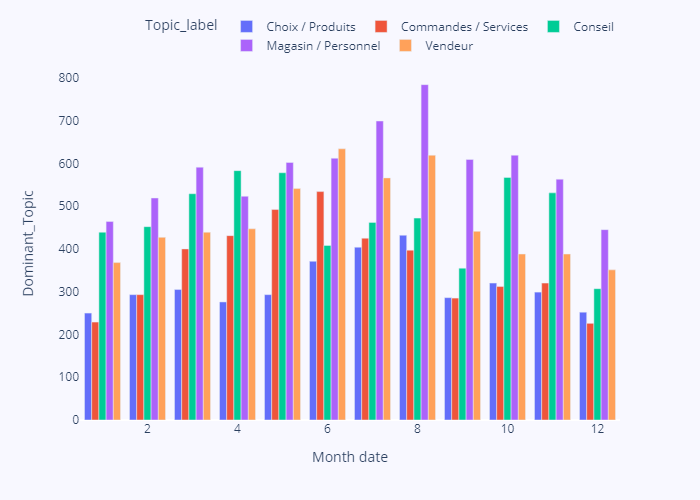

In [34]:
test_pl = df_visu.groupby(['Month date','Topic_label'], as_index=False)['Dominant_Topic'].count()

fig = px.bar(test_pl, x="Month date", 
y="Dominant_Topic",
color="Topic_label", barmode='group')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),xaxis=dict(
        showgrid=False,
        showline=False
    ),yaxis=dict(
        showgrid=False,
        showline=False
    ),paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)')
fig.show("png")

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

4    7030
2    5683
0    5609
3    4344
1    3781
Name: Dominant_Topic, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f845218-ef22-4820-ba52-835f1cb252fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>